# Preâmbulo

Imports, funções, downloads e instalação do Pytorch.

In [1]:
 # Basic imports.
import os
import time
import numpy as np
import torch

from torch import nn
from torch import optim

from torch.utils.data import DataLoader
from torch.utils import data
from torch.backends import cudnn

from torchvision import models
from torchvision import datasets
from torchvision import transforms

from skimage import io

from sklearn import metrics

from matplotlib import pyplot as plt

%matplotlib inline

cudnn.benchmark = True

In [2]:
# Setting predefined arguments.
args = {
    'epoch_num': 10,      # Number of epochs.
    'n_classes': 10,      # Number of classes.
    'lr': 0.001,          # Learning rate.
    'weight_decay': 1e-5, # L2 penalty.
    'num_workers': 3,     # Number of workers on data loader.
    'batch_size': 100,    # Mini-batch size.
    'print_freq': 1,      # Printing frequency.
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


# Carregando o  MNIST

In [3]:
# Root directory for the dataset (to be downloaded).
root = './'

# Transformations over the dataset.
data_transforms = transforms.Compose([
    transforms.ToTensor()
])

# Setting datasets and dataloaders.
train_set = datasets.MNIST(root,
                           train=True,
                           download=True,
                           transform=data_transforms)
test_set = datasets.MNIST(root,
                          train=False,
                          download=False,
                          transform=data_transforms)

# Setting dataloaders.
train_loader = DataLoader(train_set,
                          args['batch_size'],
                          num_workers=args['num_workers'],
                          shuffle=True)
test_loader = DataLoader(test_set,
                         args['batch_size'],
                         num_workers=args['num_workers'],
                         shuffle=False)

# Printing training and testing dataset sizes.
print('Size of training set: ' + str(len(train_set)) + ' samples')
print('Size of test set: ' + str(len(test_set)) + ' samples')

Size of training set: 60000 samples
Size of test set: 10000 samples


# AutoEncoder Linear

Todo AutoEncoder (AE) é composto de uma arquitetura Encoder-Decoder, assim como algumas redes para segmentação semântica que vimos na semana passada (i.e. [U-Nets](https://arxiv.org/pdf/1505.04597.pdf) ou [SegNets](https://arxiv.org/pdf/1511.00561.pdf)). AEs tradicionais não eram treinados usando backpropagation, mas sim com o método de **Stacking** de pares de camadas, caracterizando uma estratégia **gulosa** que ignorava interdependências entre pesos de diferentes camadas. O treinamento dessas redes era feito usando **Stacking** porque o algoritmo de backpropagation que vimos ao longo do curso ainda não era estável o bastante na época que os AEs surgiram na literatura, não conseguindo propagar os erros em redes com mais camadas escondidas. AEs atuais são treinados usando backpropagation assim como as outras arquiteturas modernas.

![Linear AE](https://www.dropbox.com/s/vdfhfz6jldmidsj/Linear_AE.png?dl=1)

O Encoder em um AE tradicional é composto de camadas lineares que diminuem a dimensionalidade dos dados progressivamente, criando uma região de bottleneck no meio da codificação.

![Linear AE Encoder](https://www.dropbox.com/s/fyozex4grkim3ze/Linear_AE_Encoder.png?dl=1)

Já as camadas do Decoder num AE recuperam gradualmente a dimensionalidade dos dados, reconstruíndo-o da forma mais fiel possível.

![Linear AE Decoder](https://www.dropbox.com/s/t67b2z8bh68ei1q/Linear_AE_Decoder.png?dl=1)

Ao se usar AEs Lineares em imagens, faz-se necessário linearizar os dados antes de enviá-los para as camadas Fully Connected da rede, lembrando sempre de recuperar as dimensões da imagem decodificada no fim da rede. Tanto a linearização quanto a recuperação da resolução espacial podem ser feitas usando o método *.view()* dos tensores.

Percebe-se que os dados passam de uma dimensionalidade alta na entrada para uma dimensionalidade consideravelmente baixa no bottleneck da rede. Portanto AEs podem ser vistos como métodos de redução de dimensionalidade -- assim como o [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) ou o [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) -- porém treináveis para atuarem em um domínio específico (no nosso caso, em reconstrução dígitos). Assim como outros métodos de redução de dimensionalidade, a intuição dos AEs é que as informações importantes para a reconstrução dos dados sejam codificadas no bottleneck enquanto as informações não importantes sejam ignoradas.

# Atividade Prática: AutoEncoder Linear

Como mencionado previamente, um AE é uma arquitetura **Encoder-Decoder** com camadas de dimensionalidade simétrica. Vamos definir um AE Linear:

1.   Crie um Encoder composto por três camadas FC que reduza gradativamente a dimensionalidade inicial dos dados ($28 \times 28 = 784$) para apenas 16 dimensões no bottleneck;
2.   Crie um Decoder com três camadas FC que receba as 16 dimensões dos dados e gradativamente reconstrua as dimensões originais dos dados de entrada;
3.   Implemente o *forward()* passando os dados pelo Encoder e subsequentemente pelo Decoder;
4.   Defina a loss function (uma loss de regressão) e o otimizador;
5.   Complete as funções *train()* e *test()* [linearizando os dados](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view), fazendo o [casting para o device correto](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.to) e passando as imagens linearizadas pelo AE. No fim, deve-se usar o criterion pré-definido para calcular a loss e computar o backpropagation.

PS.: as ativações de todas as camadas lineares devem ser ReLU, menos a última camada que deve ter como ativação uma função sigmóide.

# Definindo a arquitetura

In [4]:
# AutoEncoder implementation.
class AutoEncoder(nn.Module):
    
    def __init__(self):

        super(AutoEncoder, self).__init__()
        
        # TO DO: define encoder.
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 16),
            nn.ReLU(inplace=True),
        )
        
        # TO DO: define decoder.
        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )
        
        self.initialize_weights()
    
    # Function for randomly initializing weights.
    def initialize_weights(self):
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
                
    def forward(self, x):
        
        # TO DO: implement forward.
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiating architecture.
net = AutoEncoder().to(args['device'])

# Printing architecture.
print(net)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=16, bias=True)
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


# Definindo o otimizador

In [5]:
# TO DO: defining optimizer.
optimizer = optim.Adam(net.parameters(),
                       lr=args['lr'],
                       weight_decay=args['weight_decay'])

# Definindo a loss

A loss de um AE tradicional pode ser vista como uma loss de regressão, como o MSE ou a Loss L1. Como pode ser visto na imagem abaixo, as classes $y$ das amostras não são usadas no treinamento de um AE, mas apenas o próprio dado de entrada $x$. A loss $\mathcal{L}$ é computada entre a reconstrução do dado $\hat{x}$ e $x$.

![Loss AE](https://www.dropbox.com/s/84w4yz09da9zxfd/Linear_AE_Loss.png?dl=1)

In [6]:
# TO DO: defining regression loss.
criterion = nn.MSELoss().to(args['device'])
#criterion = nn.L1Loss().to(args['device'])

# Criando funções para Treino e Teste

In [7]:
# Training procedure.
def train(train_loader, net, criterion, optimizer, epoch):

    tic = time.time()
    
    # Setting network for training mode.
    net.train()

    # Lists for losses and metrics.
    train_loss = []
    
    # Iterating over batches.
    for i, batch_data in enumerate(train_loader):

        # Obtaining images and labels for batch.
        inps, labs = batch_data
        
        # TO DO: Casting to cuda variables and reshaping.
        inps = inps.view(inps.size(0), -1).to(args['device'])
        
        # TO DO: Clearing the gradients of optimizer.
        optimizer.zero_grad()

        # TO DO: Forwarding.
        outs = net(inps)

        # TO DO: Computing loss.
        loss = criterion(outs, inps)

        # TO DO: Computing backpropagation.
        loss.backward()
        
        # TO DO: Taking step in optimizer.
        optimizer.step()
        
        # Updating lists.
        train_loss.append(loss.data.item())
    
    toc = time.time()
    
    train_loss = np.asarray(train_loss)
    
    # Printing training epoch loss and metrics.
    print('-------------------------------------------------------------------')
    print('[epoch %d], [train loss %.4f +/- %.4f], [training time %.2f]' % (
        epoch, train_loss.mean(), train_loss.std(), (toc - tic)))
    print('-------------------------------------------------------------------')
    

In [8]:
# Testing procedure.
def test(test_loader, net, criterion, epoch):

    tic = time.time()
    
    # Setting network for evaluation mode.
    net.eval()

    # Lists for losses and metrics.
    test_loss = []
    
    # Iterating over batches.
    for i, batch_data in enumerate(test_loader):

        # Obtaining images and labels for batch.
        inps, labs = batch_data

        # TO DO: Casting to cuda variables and reshaping.
        inps = inps.view(inps.size(0), -1).to(args['device'])

        # TO DO: Forwarding.
        outs = net(inps)

        # TO DO: Computing loss.
        loss = criterion(outs, inps)
        
        # Updating lists.
        test_loss.append(loss.data.item())
        
        # Plotting.
        if i == 0 and epoch % args['print_freq'] == 0:
            
            fig, ax = plt.subplots(2, 8, figsize=(24, 6))
        
        if i < 8 and epoch % args['print_freq'] == 0:
            
            ax[0, i].imshow(inps.view(inps.size(0), 28, 28)[0].detach().cpu().numpy())
            ax[0, i].set_yticks([])
            ax[0, i].set_xticks([])
            ax[0, i].set_title('Image ' + str(i + 1))
            
            ax[1, i].imshow(outs.view(inps.size(0), 28, 28)[0].detach().cpu().numpy())
            ax[1, i].set_yticks([])
            ax[1, i].set_xticks([])
            ax[1, i].set_title('Reconstructed ' + str(i + 1))
            
        if i == 8 and epoch % args['print_freq'] == 0:
            
            plt.show()
    
    toc = time.time()
    
    test_loss = np.asarray(test_loss)
    
    # Printing training epoch loss and metrics.
    print('-------------------------------------------------------------------')
    print('[epoch %d], [test loss %.4f +/- %.4f], [testing time %.2f]' % (
        epoch, test_loss.mean(), test_loss.std(), (toc - tic)))
    print('-------------------------------------------------------------------')

# Iterando sobre epochs

-------------------------------------------------------------------
[epoch 1], [train loss 0.0699 +/- 0.0344], [training time 6.61]
-------------------------------------------------------------------


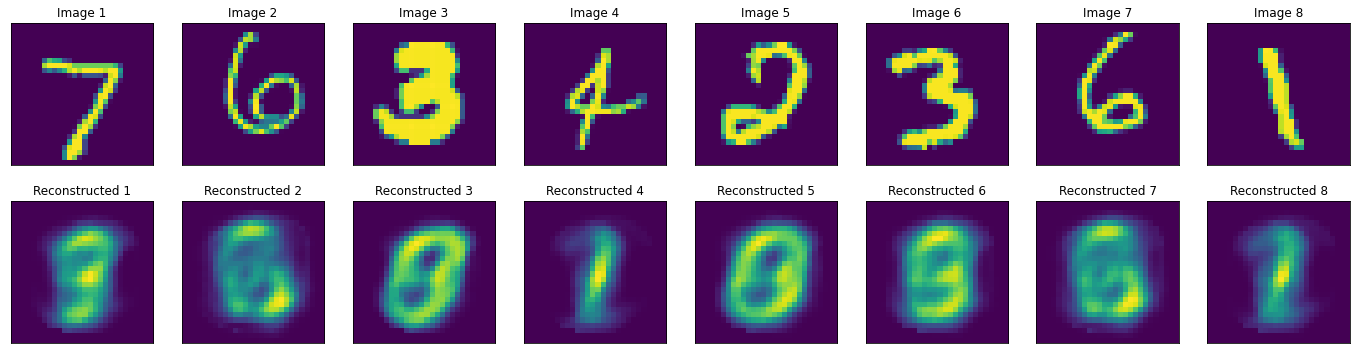

-------------------------------------------------------------------
[epoch 1], [test loss 0.0566 +/- 0.0040], [testing time 1.47]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 2], [train loss 0.0554 +/- 0.0019], [training time 6.64]
-------------------------------------------------------------------


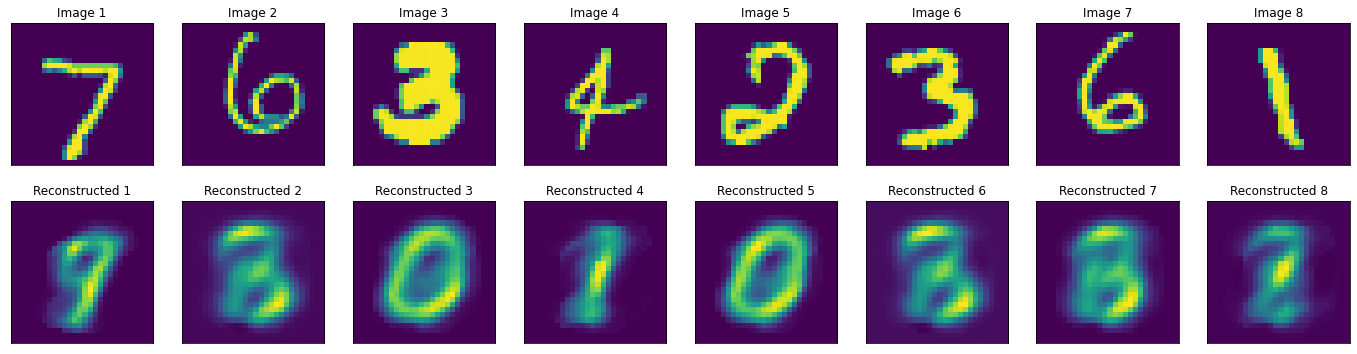

-------------------------------------------------------------------
[epoch 2], [test loss 0.0539 +/- 0.0039], [testing time 1.50]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 3], [train loss 0.0508 +/- 0.0026], [training time 6.68]
-------------------------------------------------------------------


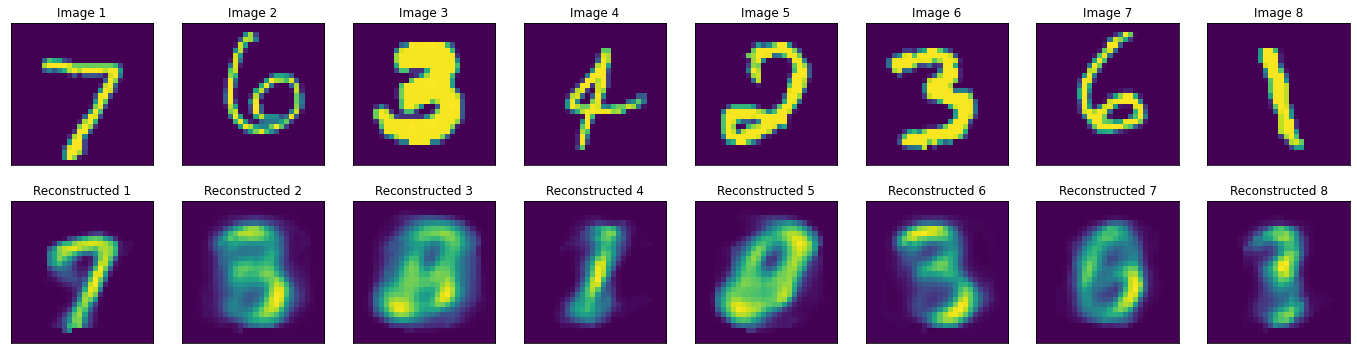

-------------------------------------------------------------------
[epoch 3], [test loss 0.0481 +/- 0.0035], [testing time 1.64]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 4], [train loss 0.0462 +/- 0.0021], [training time 6.86]
-------------------------------------------------------------------


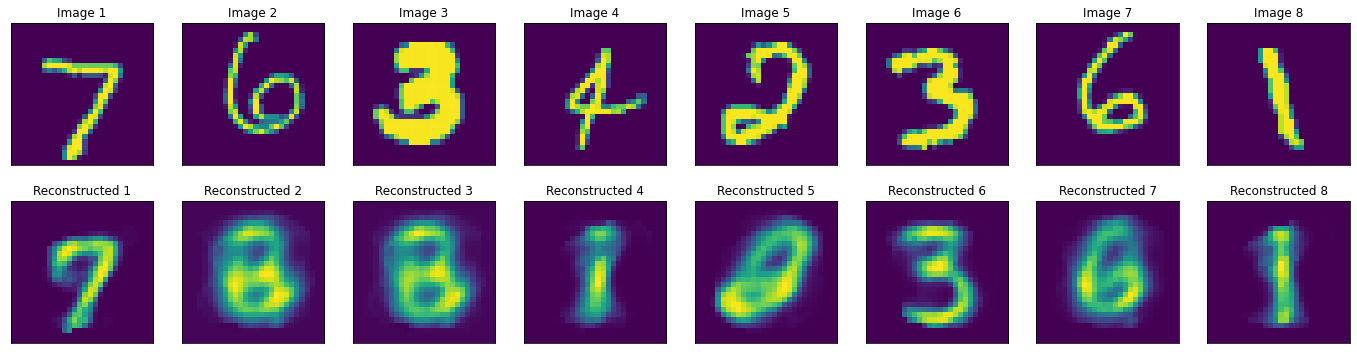

-------------------------------------------------------------------
[epoch 4], [test loss 0.0444 +/- 0.0034], [testing time 1.48]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 5], [train loss 0.0436 +/- 0.0019], [training time 6.78]
-------------------------------------------------------------------


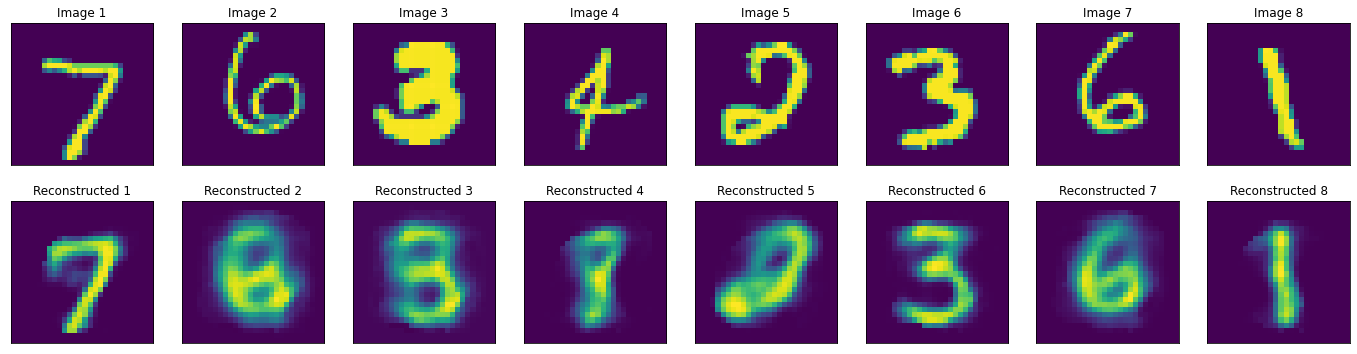

-------------------------------------------------------------------
[epoch 5], [test loss 0.0425 +/- 0.0034], [testing time 1.46]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 6], [train loss 0.0410 +/- 0.0022], [training time 6.91]
-------------------------------------------------------------------


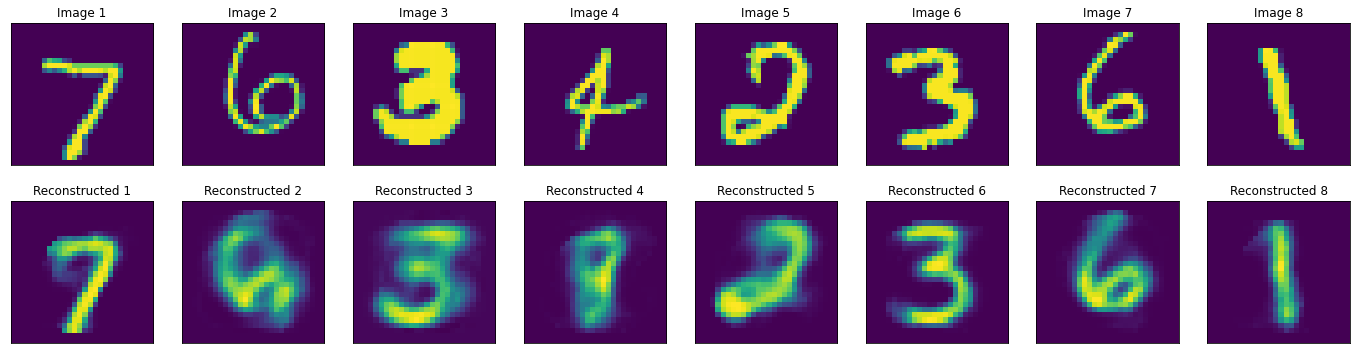

-------------------------------------------------------------------
[epoch 6], [test loss 0.0384 +/- 0.0031], [testing time 1.57]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 7], [train loss 0.0374 +/- 0.0018], [training time 6.56]
-------------------------------------------------------------------


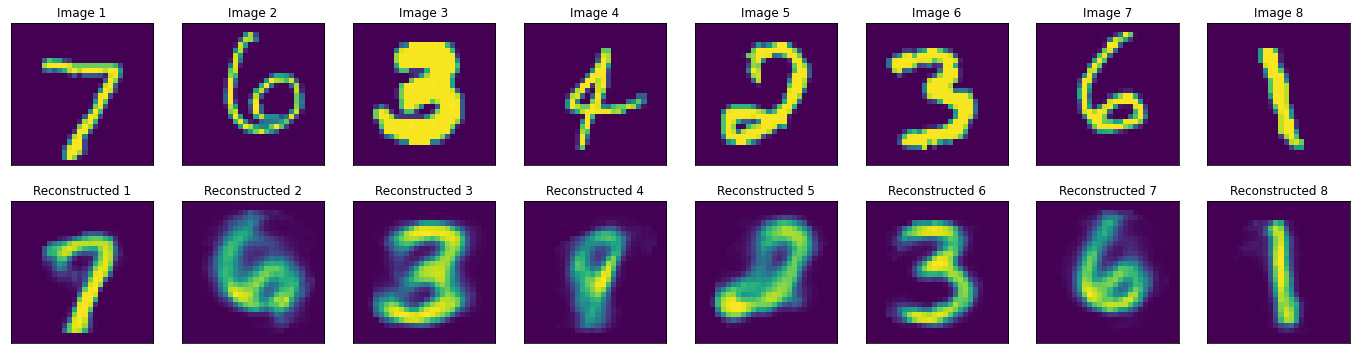

-------------------------------------------------------------------
[epoch 7], [test loss 0.0362 +/- 0.0030], [testing time 1.53]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 8], [train loss 0.0356 +/- 0.0016], [training time 7.10]
-------------------------------------------------------------------


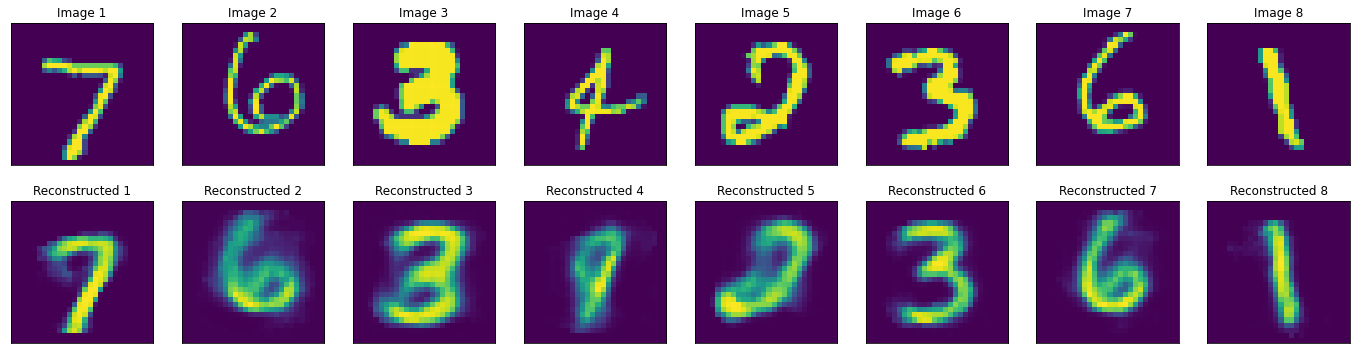

-------------------------------------------------------------------
[epoch 8], [test loss 0.0349 +/- 0.0030], [testing time 1.73]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 9], [train loss 0.0345 +/- 0.0016], [training time 6.68]
-------------------------------------------------------------------


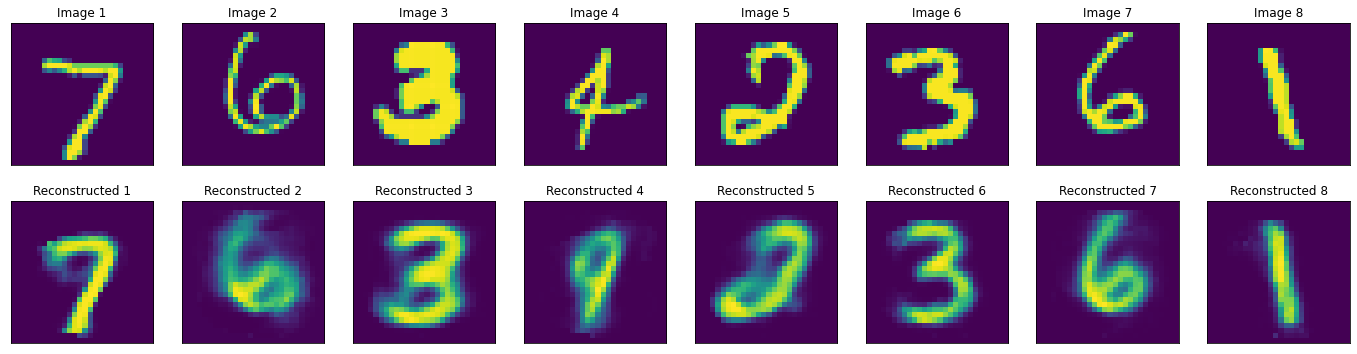

-------------------------------------------------------------------
[epoch 9], [test loss 0.0338 +/- 0.0028], [testing time 1.46]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 10], [train loss 0.0337 +/- 0.0017], [training time 6.53]
-------------------------------------------------------------------


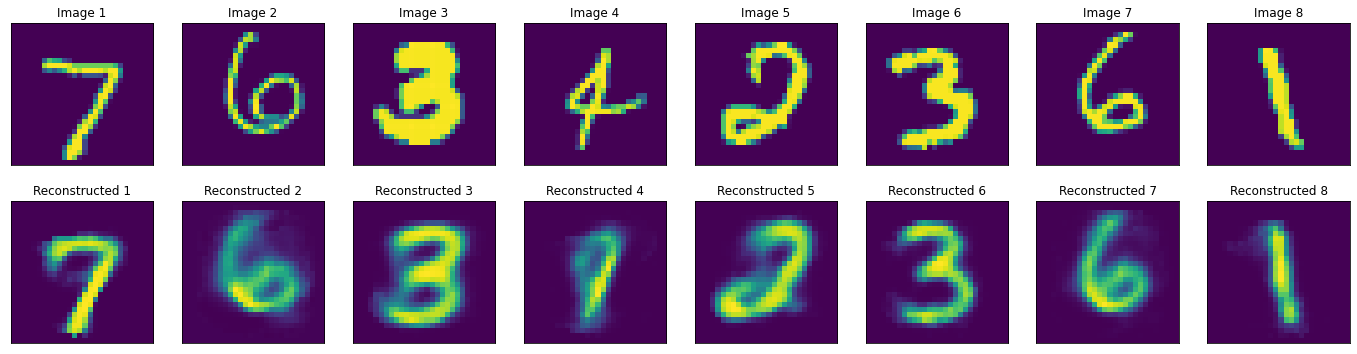

-------------------------------------------------------------------
[epoch 10], [test loss 0.0333 +/- 0.0028], [testing time 1.58]
-------------------------------------------------------------------


In [9]:
# Iterating over epochs.
for epoch in range(1, args['epoch_num'] + 1):

    # Training function.
    train(train_loader, net, criterion, optimizer, epoch)

    # Computing test loss and metrics.
    test(test_loader, net, criterion, epoch)

# Atividade Prática: Usando o Encoder como Extrator

In [10]:
# AutoEncoder implementation.
class AutoEncoder(nn.Module):
    
    def __init__(self):

        super(AutoEncoder, self).__init__()
        
        # TO DO: define encoder.
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 16),
            nn.ReLU(inplace=True),
        )
        
        # TO DO: define decoder.
        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )
        
        self.initialize_weights()
    
    # Function for randomly initializing weights.
    def initialize_weights(self):
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
                
    def forward(self, x):
        
        # TO DO: implement forward.
        x = self.encoder(x)
        cods = x
        x = self.decoder(x)
        return x, cods

# Instantiating architecture.
net = AutoEncoder().to(args['device'])

# Printing architecture.
print(net)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=16, bias=True)
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


In [11]:
from sklearn import svm
from sklearn import ensemble
from sklearn import metrics

# Evaluating procedure for digit classification.
def evaluate(train_loader, test_loader, net):
    
    tic = time.time()
    
    # Setting network for evaluation mode.
    net.eval()

    # Lists for features and labels.
    train_samples = []
    train_labels = []
    
    test_samples = []
    test_labels = []
    
    # TO DO: Iterating over training batches.
    for i, batch_data in enumerate(train_loader):

        # TO DO: Obtaining images and labels for batch.
        inps, labs = batch_data

        # TO DO: Casting to cuda variables and reshaping.
        inps = inps.view(inps.size(0), -1).to(args['device'])

        # TO DO: Forwarding.
        outs, cods = net(inps)
        
        # Iterating over images in batch.
        for b in range(inps.size(0)):
            
            features = cods[b].detach().cpu().numpy().ravel()
            label = labs[b].detach().item()
            
            train_samples.append(features)
            train_labels.append(label)

    # TO DO: Iterating over test batches.
    for i, batch_data in enumerate(test_loader):

        # TO DO: Obtaining images and labels for batch.
        inps, labs = batch_data

        # TO DO: Casting to cuda variables and reshaping.
        inps = inps.view(inps.size(0), -1).to(args['device'])

        # TO DO: Forwarding.
        outs, cods = net(inps)
        
        # Iterating over images in batch.
        for b in range(inps.size(0)):
            
            features = cods[b].detach().cpu().numpy().ravel()
            label = labs[b].detach().item()
            
            test_samples.append(features)
            test_labels.append(label)
    
    # TO DO: Transforming lists to numpy arrays.
    train_samples = np.asarray(train_samples)
    train_labels = np.asarray(train_labels)
    
    test_samples = np.asarray(test_samples)
    test_labels = np.asarray(test_labels)
    
    
    # TO DO: Instantiating Random Forest.
    clf_rf = ensemble.RandomForestClassifier(n_estimators=50)
    
    # TO DO: Fitting training data.
    clf_rf.fit(train_samples, train_labels)
    
    # TO DO: Predicting test data.
    test_preds_rf = clf_rf.predict(test_samples)
    
    # TO DO: Computing accuracy.
    acc_rf = metrics.accuracy_score(test_labels, test_preds_rf)
    
    
    toc = time.time()
    
    # Using the features to perform classification on a supervised setting.
    print('-------------------------------------------------------------------')
    print('[rf accuracy %.4f], [time %.2f]' % (
        acc_rf, (toc - tic)))
    print('-------------------------------------------------------------------')
    
# Calling evaluation function.
evaluate(train_loader, test_loader, net)

-------------------------------------------------------------------
[rf accuracy 0.6149], [time 18.77]
-------------------------------------------------------------------
